In [2]:
from scipy import ndimage
from deuces.card import Card
from scipy import misc
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np
from pytesser import *
#from skimage.feature import match_template
#import skimage.feature
import os
import PIL
import time
import pyautogui as gui
import re
from PokerMath import PokerMath
%matplotlib inline


In [195]:
# coding: utf-8
# %load ImageProcessor.py
# %load ImageProcessor.py
#%save ImageProcessor.py 12

from scipy import ndimage
from deuces.card import Card
from scipy import misc
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np
from pytesser import *
import os
import PIL
import time
import pyautogui as gui
import re
import time
get_ipython().magic(u'matplotlib inline')

class Frame(): 
    def __init__(self, blinds = .05):
        '''Locate the Bovada window and initialize variables '''
    
        ## initialize the bovada logo reference image
        ## Everytime the frame updates, it must locate the Bovada logo as a reference point
        self.BOVADA_REF_IMG = PIL.Image.open("reference_images/BOVADA.png")
        
        self.blinds = blinds
        
        ## These are the coordinates of where the important values
        ## exist in the frame, relative to the bovada logo
        ## top left and bottom right coords of bounding box
        self.LOCATIONS = {
                'hole1' : ((353, 428),(401, 496)), 
                'hole2' : ((403, 428),(451, 496)), 
                'board1' : ((269,242), (317, 310)),
                'board2' : ((323,242), (371, 310)), 
                'board3' : ((377,242), (425, 310)),
                'board4' : ((431,242), (479, 310)), 
                'board5' : ((485,242), (533, 310)),
                'pot'    : ((350, 312), (470, 330)),
                'blinds' : ((0, 35), (150, 50)),
                'textBar': ((670, 590),(750, 605)),
                'fold'   : ((420, 560), (520, 580)),
                'stack0' : ((380, 470), (480, 495)),
                'stack1' : ((70, 395), (170, 420)),
                'stack2' : ((70, 180), (170, 205)),
                'stack3' : ((330, 105), (430, 130)),
                'stack4' : ((630, 180), (730, 205)),
                'stack5' : ((630, 395), (730, 420)),
                'bet0'   : ((390, 410),(490, 425)),
                'bet1'   : ((190, 355), (300, 370)),
                'bet2'   : ((190, 230), (300, 245)),
                'bet3'   : ((400, 172), (500, 185)),
                'bet4'   : ((560, 232), (680, 245)),
                'bet5'   : ((580, 347), (680, 360))
        }                  
        
        
        
        ## Coordinates of where dealer button can exist
        self.DEALER_LOC = [(264, 422),(137,302),(220, 165),(530, 150),(660, 275),(570, 408)]
        
        ## save a screen shot   
        os.system("screencapture screenshots/test.jpg")
        
        ## locate the bovada symbol on screen to find the bovada window
        try:
            self.x,self.y,width,height = gui.locate(self.BOVADA_REF_IMG, PIL.Image.open("screenshots/test.jpg"))
        except TypeError:
            raise Exception("Can't locate frame")

             
        ## save the bovada application window (as an image)
        img = misc.imread('screenshots/test.jpg', flatten = True)
        self.frame = img[self.y:self.y + 650, self.x:self.x + 750]  
        
        
        ## load the suit reference functions used to identify card suits
        self.SUIT_REF_FUNCTIONS = []
        heart = misc.imread("reference_images/suits/HEART.jpg", flatten = True)
        diamond = misc.imread("reference_images/suits/DIAMOND.jpg", flatten = True)
        spade = misc.imread("reference_images/suits/SPADE.jpg", flatten = True)
        club = misc.imread("reference_images/suits/CLUB.jpg", flatten = True) 
        self.SUIT_REF_FUNCTIONS.append(('h', heart.sum(axis = 1)))
        self.SUIT_REF_FUNCTIONS.append(('c', club.sum(axis = 1)))
        self.SUIT_REF_FUNCTIONS.append(('d', diamond.sum(axis = 1)))
        self.SUIT_REF_FUNCTIONS.append(('s', spade.sum(axis = 1)))
        
        
    def update(self):
        #Takes a picture of the frame, assuming the frame has not moved from previous position
        os.system("screencapture screenshots/test.jpg")
        img = misc.imread('screenshots/test.jpg', flatten = True)
        self.frame = img[self.y:self.y + 650, self.x:self.x + 750]  
        
    
    
    def identify_card(self, card_str):
        '''Locates card on screen given by card_str parameter and returns a string identifying the card.
           As is Ace of spades, Tc is ten of clubs, etc.
           
           params : hole1, hole2, board1, board2, ect...'''
              
        v = self.LOCATIONS[card_str]
        card_img = self.frame[v[0][1]:v[1][1], v[0][0]:v[1][0]] 
        num_img = card_img[2:19, 0:19]
        suit_img = card_img[19:35, :17]
         
        
        ## identify the number
        blank = np.ones((num_img.shape[0] * 2, num_img.shape[1] * 7))*245
        for i in range(0, 20*6, 20):
            blank[:num_img.shape[0], i :num_img.shape[1] + i] = num_img
               
        num_img = PIL.Image.fromarray(np.uint8(blank))
        num_str =  image_to_string(num_img)
        
        ## tesseract reads 10 as 1 because it's just grabbing the first digit    
        try:
            num_str = num_str[0]
            if num_str == '1':
                num_str = 'T'
        except IndexError:
            return 'None'
        
        
    
        f = suit_img.sum(axis = 1)
        diff = lambda x : abs((f**2 - x[1]**2).sum())
        suit_str = min(self.SUIT_REF_FUNCTIONS, key = diff)[0]
                
        
        return num_str + suit_str
    
    
    def read_value(self, loc):
        pos = self.LOCATIONS[loc]
        v = self.frame[pos[0][1]:pos[1][1], pos[0][0]:pos[1][0]]
        x,y = v.shape
        f = PIL.Image.fromarray(np.uint8(v))
        #f.show()
        basewidth = 300
        wpercent = (basewidth/float(f.size[0]))
        hsize = int((float(f.size[1])*float(wpercent)))
        img = f.resize((basewidth,hsize), PIL.Image.ANTIALIAS)
        #img.show()
        s = image_to_string(img)
        #print s
        
        
        if loc is 'blinds':
            non_decimal = re.compile(r'[^\d,]+')
            s = non_decimal.sub(' ', s)
            s = s.replace(',', '')
            s = s.split(' ')[1]
            
        else:
            non_decimal = re.compile(r'[^\d.]+')
            s = non_decimal.sub('', s)
        
        return s
                 
    def bet(self, n):
        v = self.LOCATIONS['textBar']
        gui.moveTo(np.random.randint(v[0][0] + self.x, v[1][0] + self.x),
                   np.random.randint(v[0][1] + self.y, v[1][1] + self.y), 
                   duration = .5)
        gui.click()
        gui.typewrite(str(n), interval=0.25)
        gui.press('enter')
    
    def fold(self):
        v = self.LOCATIONS['fold']
        gui.moveTo(np.random.randint(v[0][0] + self.x, v[1][0] + self.x),
                   np.random.randint(v[0][1] + self.y, v[1][1] + self.y), 
                   duration = .5)
        
        time.sleep(.5)
        gui.click()


    def user_position(self):
        positions = ['D', 'SB', 'BB','UTG', 'MP', 'CO']
        color = lambda x : self.frame[x[1], x[0]]
        button = self.DEALER_LOC.index(max(self.DEALER_LOC, key = color))
        return positions[(6 - button) % 6]
    
    def in_hand(self):
        in_hand = np.empty(6, dtype='bool')
        for i in range(6):
            pos = self.LOCATIONS['stack%s'%i]
            slice = self.frame[pos[0][1]:pos[1][1], pos[0][0]:pos[1][0]]
            in_hand[i] = len(slice[slice > 200]) > 50
        return in_hand
    
    def bets(self):
        bets = np.zeros(5)
        for i in range(1, 6):
            bet = self.read_value('bet%s'%i)      
            try:
                bets[i - 1] = bet
            except ValueError:
                bets[i - 1] = 0
        return bets
            
    
    def is_user_turn(self):
        img = misc.imread('screenshots/test.jpg', flatten = False)
        img = img[self.y:self.y + 650, self.x:self.x + 750]  
        
        slice = img[500:515, 330:450]
        slice = slice.reshape(slice.shape[0]*slice.shape[1], 4)
        yellow_mask = (slice[:,0] > 200) & (slice[:,1] > 200) & (slice[:,2] == 0)
        
        return len(slice[yellow_mask]) > 0
        
        """
        pos = self.LOCATIONS['stack0']
        slice = self.frame[pos[0][1] + 30:pos[1][1]+20, pos[0][0]:pos[1][0]]
        #plt.imshow(slice)
        #bins = plt.hist(slice)
        return len(slice[slice > 50]) > 50
        """
    
    
    def is_unopened(self):
        return len(a[a == .5]) == 1
    
    
    
    
                

In [58]:
frame = Frame()

In [99]:
frame.update()
'''

pocket1 = Card.new(frame.identify_card('hole1'))
pocket2 = Card.new(frame.identify_card('hole2'))

hand = [pocket1, pocket2]'''
    
board = []
for i in range(1, 6):
    card = frame.identify_card('board%s'%i)
    if card is not 'None':
        board.append(Card.new(card))
        

Card.print_pretty_cards(board)
#Card.print_pretty_cards(hole)

print 'pot:' , frame.read_value('pot')
'''
for i in range(6):
    try:
        print 'player %s : '%i ,frame.read_value(i)
    except: "cant red %s"%i
        '''
print 'dealer position: ' , frame.dealer_position()
print 'blinds: ' , frame.read_value('blinds')
        
      
        
       

  [ 9 ❤ ] , [ T ♠ ] , [ 7 ♠ ]  
pot: 57.96
dealer position:  3
blinds:  2


In [3]:
frame = Frame()

"\nf = PIL.Image.fromarray(np.uint8(f))\n\ndef scale(f):\n    basewidth = 300\n    wpercent = (basewidth/float(f.size[0]))\n    hsize = int((float(f.size[1])*float(wpercent)))\n    img = f.resize((basewidth,hsize), PIL.Image.ANTIALIAS)\n    img.show()\n    return img\n\nf = scale(f)\ns = image_to_string(f)\nnon_decimal = re.compile(r'[^\\d.]+')\ns = non_decimal.sub(' ', s)\nprint s"

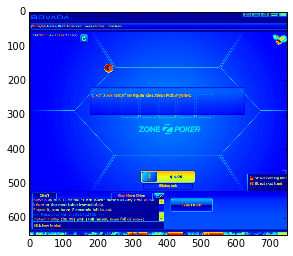

In [17]:
frame.update()
f = frame.frame
plt.imshow(f)

y1 = 380
y2 = 425
x1 = 350
x2 = 450

(390, 410),(490, 425)



f = f[y1:y2, x1:x2]
#plt.imshow(f)




'''
f = PIL.Image.fromarray(np.uint8(f))

def scale(f):
    basewidth = 300
    wpercent = (basewidth/float(f.size[0]))
    hsize = int((float(f.size[1])*float(wpercent)))
    img = f.resize((basewidth,hsize), PIL.Image.ANTIALIAS)
    img.show()
    return img

f = scale(f)
s = image_to_string(f)
non_decimal = re.compile(r'[^\d.]+')
s = non_decimal.sub(' ', s)
print s'''

(array([  2.40000000e+01,   3.00000000e+00,   6.00000000e+00,
          3.10000000e+01,   4.96000000e+02,   3.49200000e+03,
          3.00000000e+01,   1.54000000e+02,   1.70000000e+01,
          8.00000000e+00,   1.60000000e+01,   1.60000000e+01,
          1.50000000e+01,   7.00000000e+00,   1.00000000e+01,
          7.00000000e+00,   1.50000000e+01,   9.00000000e+00,
          2.10000000e+01,   1.23000000e+02]),
 array([   0.  ,   12.75,   25.5 ,   38.25,   51.  ,   63.75,   76.5 ,
          89.25,  102.  ,  114.75,  127.5 ,  140.25,  153.  ,  165.75,
         178.5 ,  191.25,  204.  ,  216.75,  229.5 ,  242.25,  255.  ]),
 <a list of 20 Patch objects>)

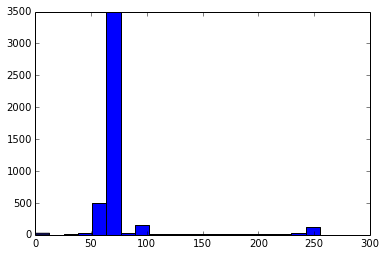

In [16]:
plt.hist(f.flatten(), bins = 20)

In [141]:
frame = Frame()

In [37]:
im = PIL.Image.open('screenshots/test.jpg')
im = im.crop((frame.x, frame.y, frame.x + 750, frame.y + 650))
im = im.crop((330, 500, 460, 515))
im.show()


In [147]:
frame.update()
img = misc.imread('screenshots/test.jpg', flatten = False)
img = img[frame.y:frame.y + 650, frame.x:frame.x + 750]  

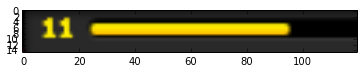

In [166]:
glow = img[500:515, 330:450]
plt.imshow(glow)

In [167]:
glow

array([[[  0,   0,   0, 255],
        [ 18,  18,  18, 255],
        [ 20,  20,  20, 255],
        ..., 
        [ 22,  22,  22, 255],
        [ 22,  22,  22, 255],
        [ 22,  22,  22, 255]],

       [[  0,   0,   0, 255],
        [ 22,  22,  22, 255],
        [ 26,  26,  26, 255],
        ..., 
        [ 29,  29,  29, 255],
        [ 29,  29,  29, 255],
        [ 29,  29,  29, 255]],

       [[  0,   0,   0, 255],
        [ 26,  26,  26, 255],
        [ 31,  31,  31, 255],
        ..., 
        [ 35,  35,  35, 255],
        [ 35,  35,  35, 255],
        [ 35,  35,  35, 255]],

       ..., 
       [[  0,   0,   0, 255],
        [ 29,  29,  29, 255],
        [ 35,  35,  35, 255],
        ..., 
        [ 41,  41,  41, 255],
        [ 41,  41,  41, 255],
        [ 41,  41,  41, 255]],

       [[ 12,   1,   1, 255],
        [ 26,  26,  26, 255],
        [ 35,  35,  35, 255],
        ..., 
        [ 41,  41,  41, 255],
        [ 41,  41,  41, 255],
        [ 41,  41,  41, 255]],

       

In [189]:
#glow = glow.reshape(glow.shape[0]*glow.shape[1], 4)
print glow
mask = (glow[:,0] > 200) & (glow[:,1] > 200) & (glow[:,2] == 0)

[[  0   0   0 255]
 [ 18  18  18 255]
 [ 20  20  20 255]
 ..., 
 [ 41  41  41 255]
 [ 41  41  41 255]
 [ 41  41  41 255]]


In [191]:
len(mask)

1800

In [187]:
b = glow[:,1] > 0

In [196]:
frame = Frame()

In [205]:
frame.update()
frame.is_user_turn()

True